<a href="https://colab.research.google.com/github/ursu-mihai77777/BrainTumorCNN/blob/main/Medical_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
!pip install split-folders
!pip install torch-summary

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')

import copy
import os

import torch
from PIL import Image

#pytorch represents the datasets
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.

import torch.nn as nn #neural networks
from torchvision import utils #working on images such as saving and visualizing

from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib

from sklearn.metrics import confusion_matrix, classification_report

import itertools

from tqdm.notebook import trange,tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [5]:
labels_df=pd.read_csv('/content/drive/MyDrive/ML/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [6]:
labels_df.shape

(4600, 6)

In [7]:
import pathlib
# Dataset Path
data_dir = '/content/drive/MyDrive/ML/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = '/content/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [02:07, 36.15 files/s] 


In [8]:
batch_size = 32

# 1. Define image transformations for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.RandomRotation(10), # Randomly rotate images by up to 10 degrees
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# 2. Define image transformations for the validation dataset
val_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# 3. Create ImageFolder datasets
train_dataset = ImageFolder(root=data_dir / 'train', transform=train_transform)
val_dataset = ImageFolder(root=data_dir / 'val', transform=val_transform)

# 4. Create DataLoader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")

Number of training samples: 3679
Number of validation samples: 921
Number of batches in training loader: 115
Number of batches in validation loader: 29


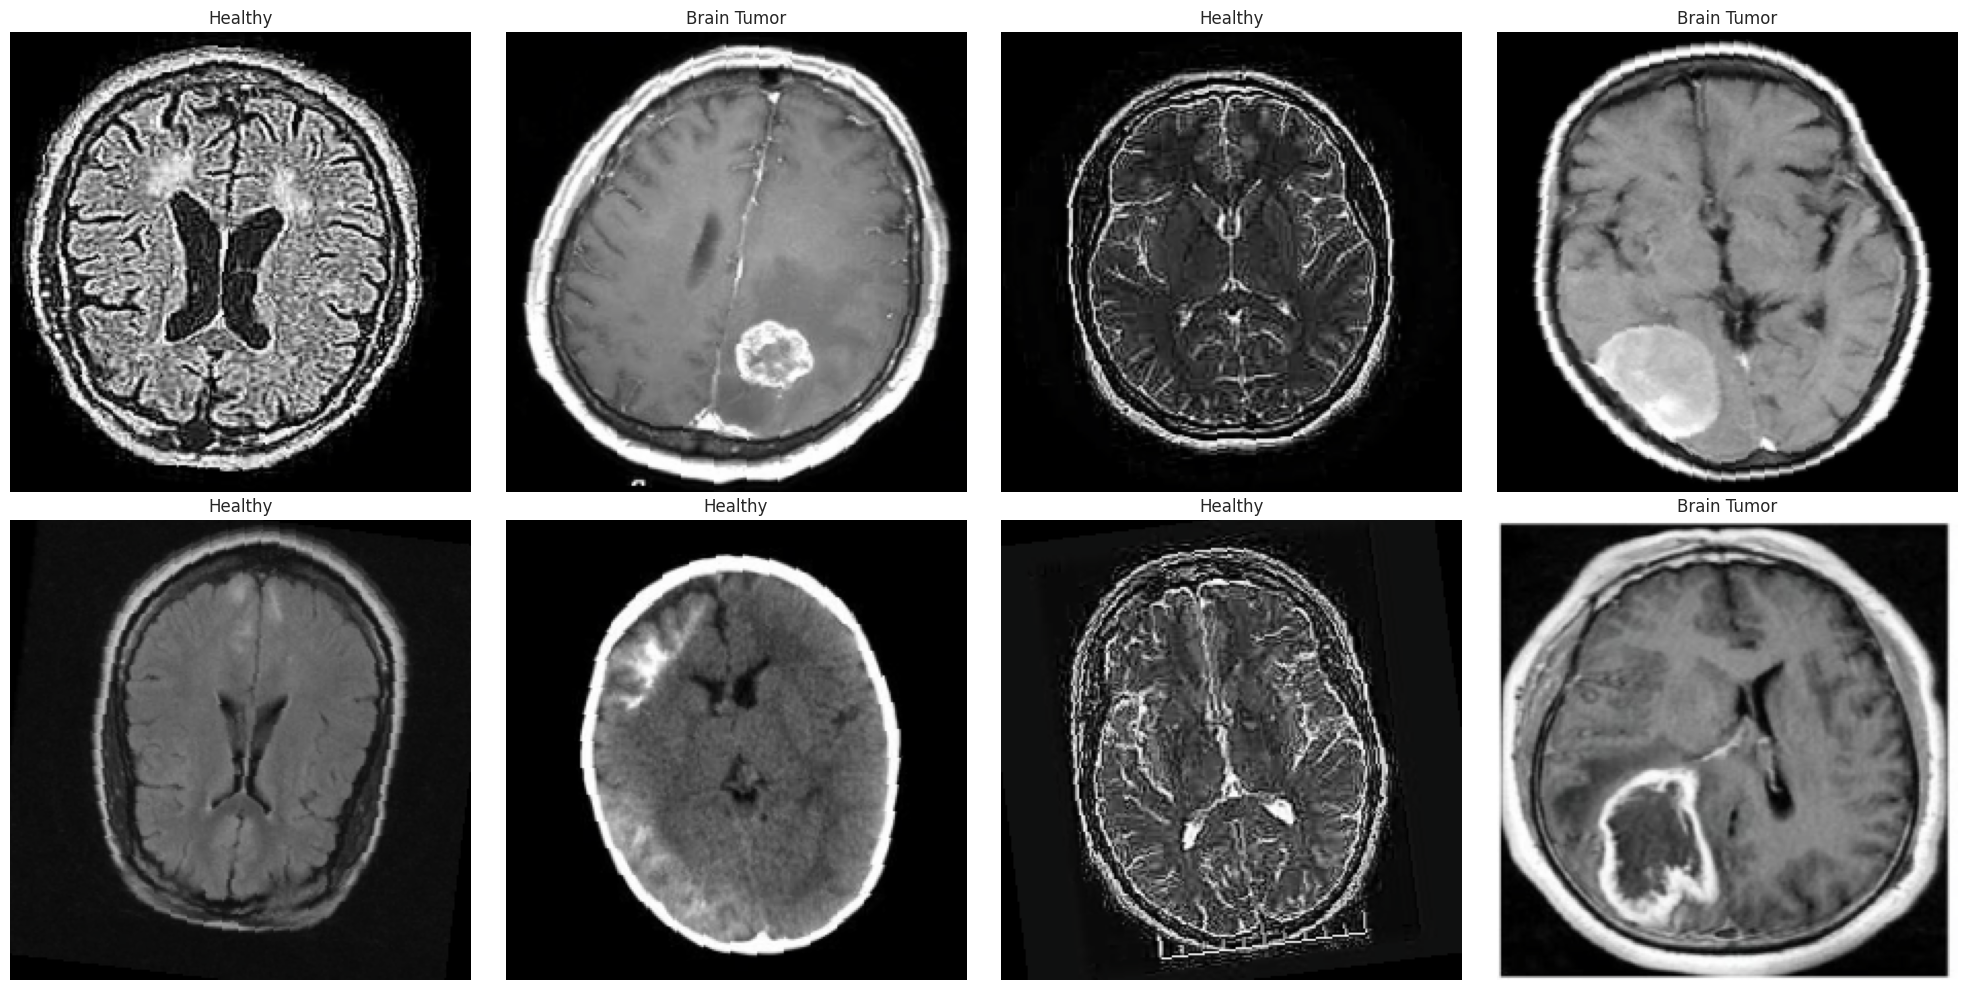

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels from the training loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert tensors to numpy arrays
X = images.numpy()
arr = labels.numpy()

# Permute the dimensions for matplotlib (batch, height, width, channels)
X = np.transpose(X, (0, 2, 3, 1))

# Denormalize the images for display
# The normalization values were mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
X = std * X + mean
X = np.clip(X, 0, 1) # Clip values to be between 0 and 1

# Get class names from the dataset
class_names = train_dataset.classes

# Display 8 images to increase the chance of seeing both classes
fig = plt.figure(figsize=(20, 10)) # Adjust figure size for more images
k=1
for i in range(8):
    a = fig.add_subplot(2, 4, k) # Arrange in 2 rows, 4 columns
    # Use the actual class name based on the label
    a.set_title(class_names[arr[i]])

    plt.imshow(X[i])
    plt.axis('off') # Hide axes for cleaner display
    k=k+1;

plt.tight_layout()
plt.show()

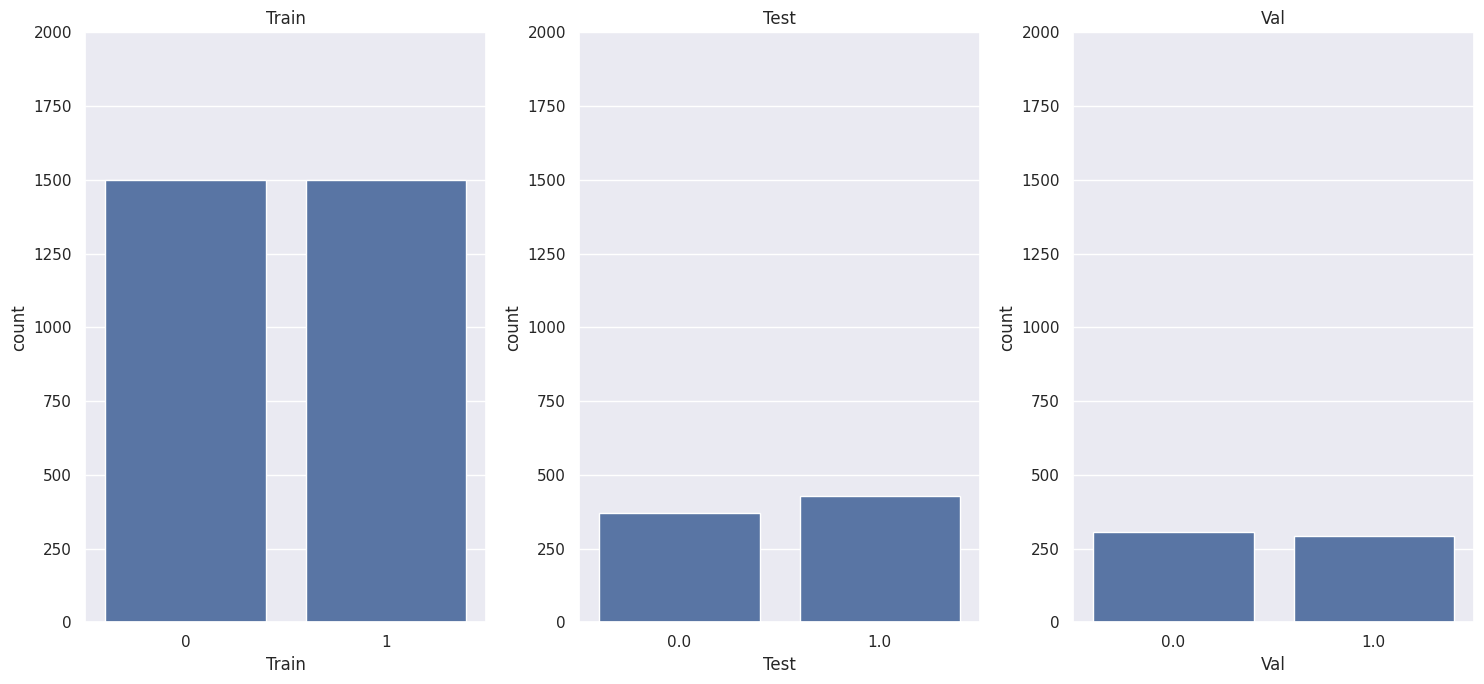

In [10]:
# 1. DEFINE MISSING VARIABLES (Replace these with your actual data lists)
# y = Train labels, t = Test labels, m = Val labels
y = np.random.choice([0, 1], size=3000)
t = np.random.choice([0, 1], size=800)
m = np.random.choice([0, 1], size=600)

# 2. CREATE DATAFRAME
# Using a dictionary ensures different lengths (Train/Test/Val) are handled correctly
df = pd.DataFrame({
    'Train': pd.Series(y),
    'Test': pd.Series(t),
    'Val': pd.Series(m)
})

# 3. PLOT
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

# Added 'x=' to fix potential Seaborn warnings
sns.countplot(x=df['Train'], ax=ax[0])
ax[0].set(ylim=(0, 2000))
ax[0].set_title('Train')

sns.countplot(x=df['Test'], ax=ax[1])
ax[1].set(ylim=(0, 2000))
ax[1].set_title('Test')

sns.countplot(x=df['Val'], ax=ax[2])
ax[2].set(ylim=(0, 2000))
ax[2].set_title('Val')

plt.tight_layout()
plt.show()

In [13]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation ='relu', input_shape =(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation ='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation ='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation ='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation ='relu'))
model.add(layers.Dense(1, activation ="sigmoid"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image paths based on the 'data_dir' variable from previous cells
# 'data_dir' was defined as pathlib.Path('/content/brain')
train_img_path = data_dir / 'train'
val_img_path = data_dir / 'val'

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_img_path, target_size =(150, 150),
                                                      batch_size = 20, class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(val_img_path, target_size =(150, 150),
                                                      batch_size = 20, class_mode = "binary")

Found 3679 images belonging to 2 classes.
Found 921 images belonging to 2 classes.


In [20]:
from keras import optimizers

model.compile(loss ="binary_crossentropy", optimizer = optimizers.RMSprop(),
metrics =['accuracy'])

history = model.fit(train_generator, steps_per_epoch = 100, epochs = 30,
validation_data = validation_generator, validation_steps = 50)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5804 - loss: 0.7418 - val_accuracy: 0.7796 - val_loss: 0.5341
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7898 - loss: 0.4700 - val_accuracy: 0.7698 - val_loss: 0.4467
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8445 - loss: 0.3499 - val_accuracy: 0.8751 - val_loss: 0.2969
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9113 - loss: 0.2596 - val_accuracy: 0.9066 - val_loss: 0.2204
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9101 - loss: 0.2180 - val_accuracy: 0.9197 - val_loss: 0.1933
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9366 - loss: 0.1585 - val_accuracy: 0.9522 - val_loss: 0.1593
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9524 - loss: 0.1267 - val_accuracy: 0.9490 - val_loss: 0.1535
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9695 - loss: 0.0835 - val_accu

(1, 150, 150, 3)


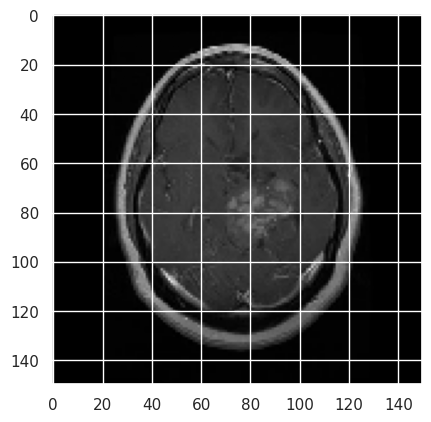

In [26]:
from keras.preprocessing import image
import numpy as np

# Define image_path using the previously defined data_dir
# Example path to an image in the training set (Brain Tumor class)
# Assuming data_dir = pathlib.Path('/content/brain') from previous cells
image_path = data_dir / 'train' / 'Brain Tumor' / 'Cancer (1).jpg'

# Pre-processing the image
img = image.load_img(image_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.

# Print image tensor shape
print(img_tensor.shape)

# Print image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
(1, 148, 148, 32)


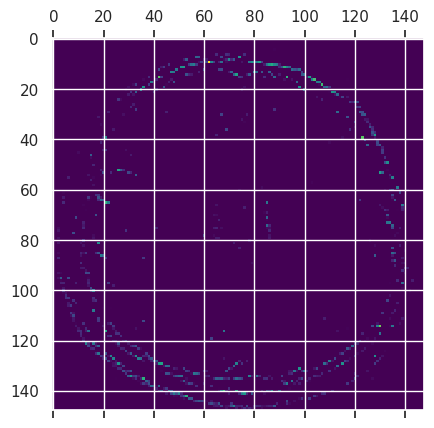

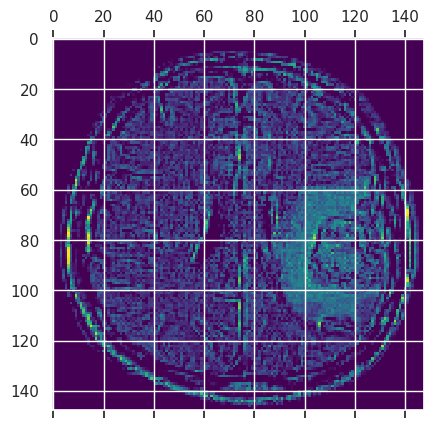

In [28]:
import numpy as np # Ensure numpy is imported for array operations
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting

# Ensure the model is built before accessing its input
# The input shape should match the input expected by the model (150, 150, 3) plus a batch dimension (None)
if not model.built:
    model.build(input_shape=(None, 150, 150, 3))

# Define img_tensor - Get one image from the generator
# Assuming train_generator is available from previous cells (PI3u0Q8xUJV5)
# If you run this cell independently, ensure train_generator is in scope.
if 'train_generator' in locals():
    images, _ = next(train_generator) # Get a batch of images
    img_tensor = np.expand_dims(images[0], axis=0) # Take the first image and add a batch dimension
else:
    print("Error: 'train_generator' is not defined. Please run the cell where it is initialized.")
    # Create a dummy tensor if train_generator is not found, to allow code to run
    img_tensor = np.random.rand(1, 150, 150, 3).astype('float32') # Use float32 for Keras input

# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.layers[0].input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

# Getting Activations of first layer
first_layer_activation = activations[0]

# shape of first layer activation
print(first_layer_activation.shape)

# 6th channel of the image after first layer of convolution is applied
plt.matshow(first_layer_activation[0, :, :, 6], cmap ='viridis')

# 15th channel of the image after first layer of convolution is applied
plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis')

In [29]:
layer_names = []

for layer in model.layers[:8]:
  layer_names.append(layer.name)
print(layer_names)

['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


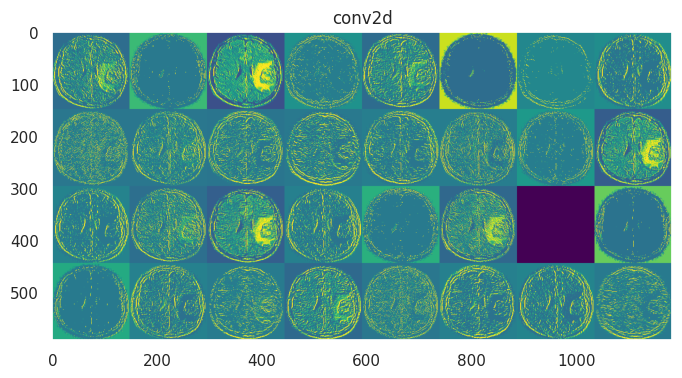

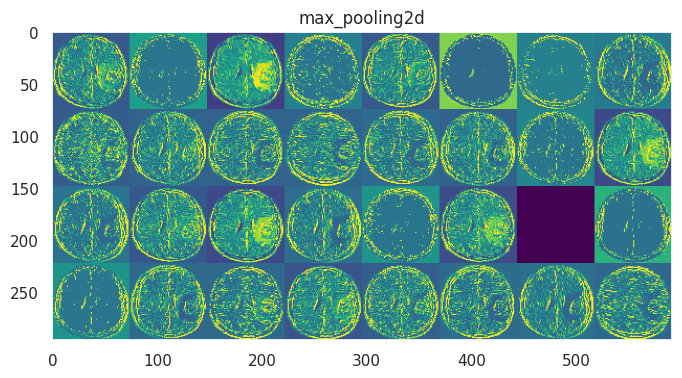

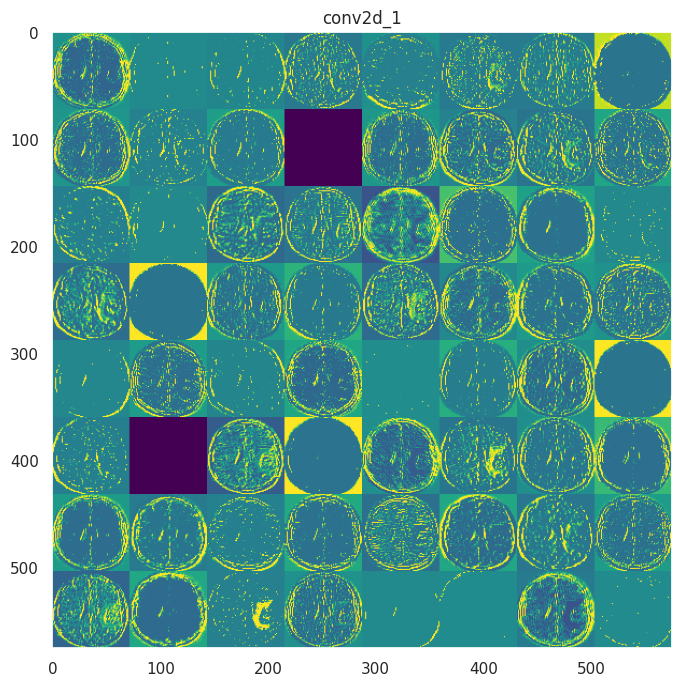

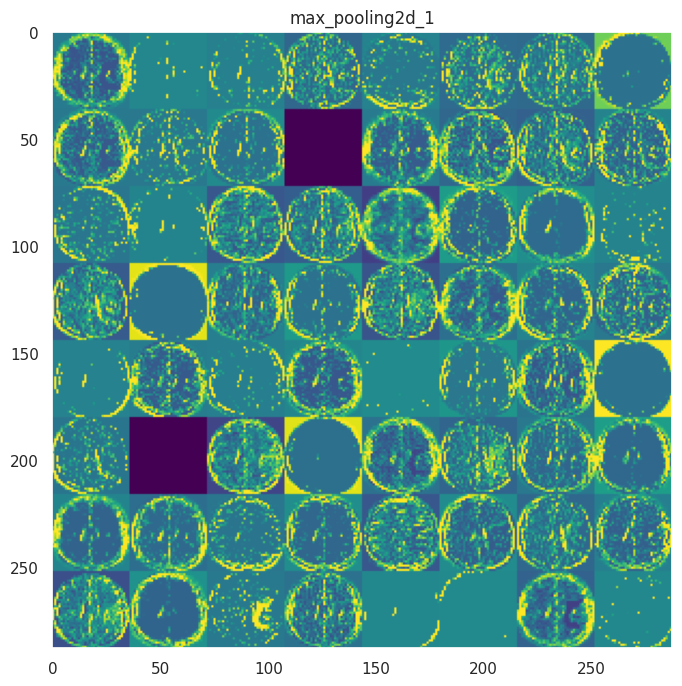

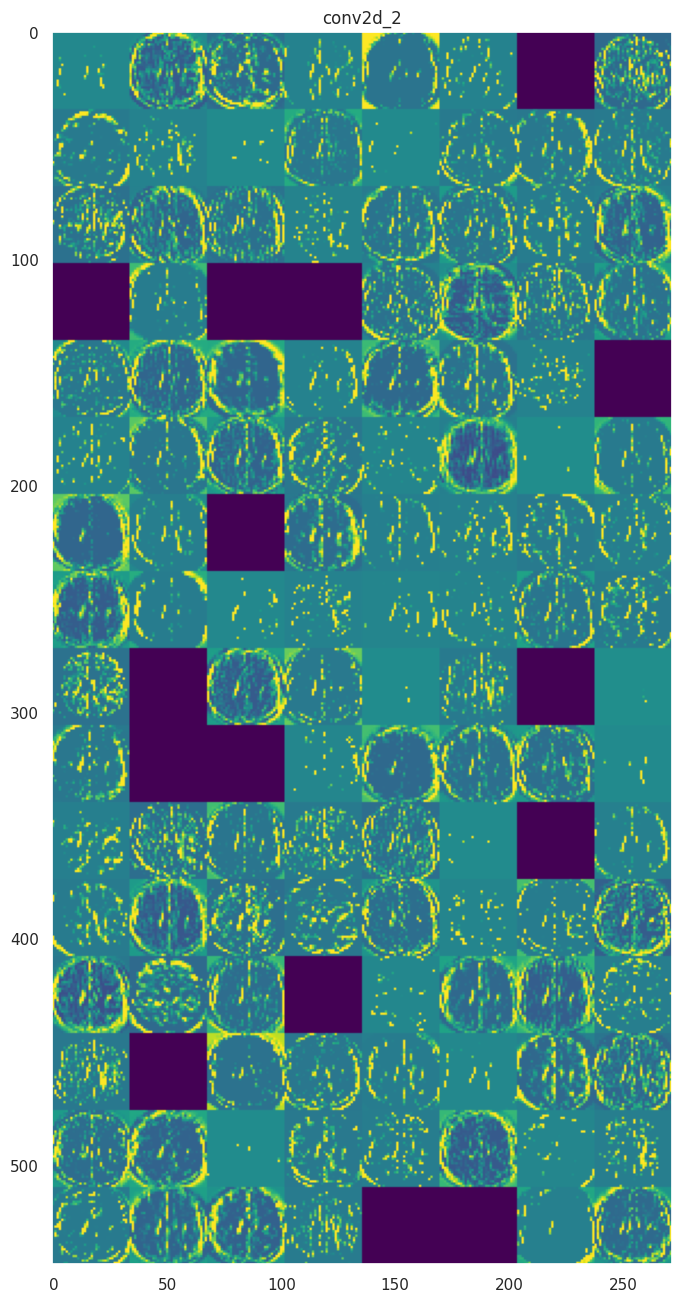

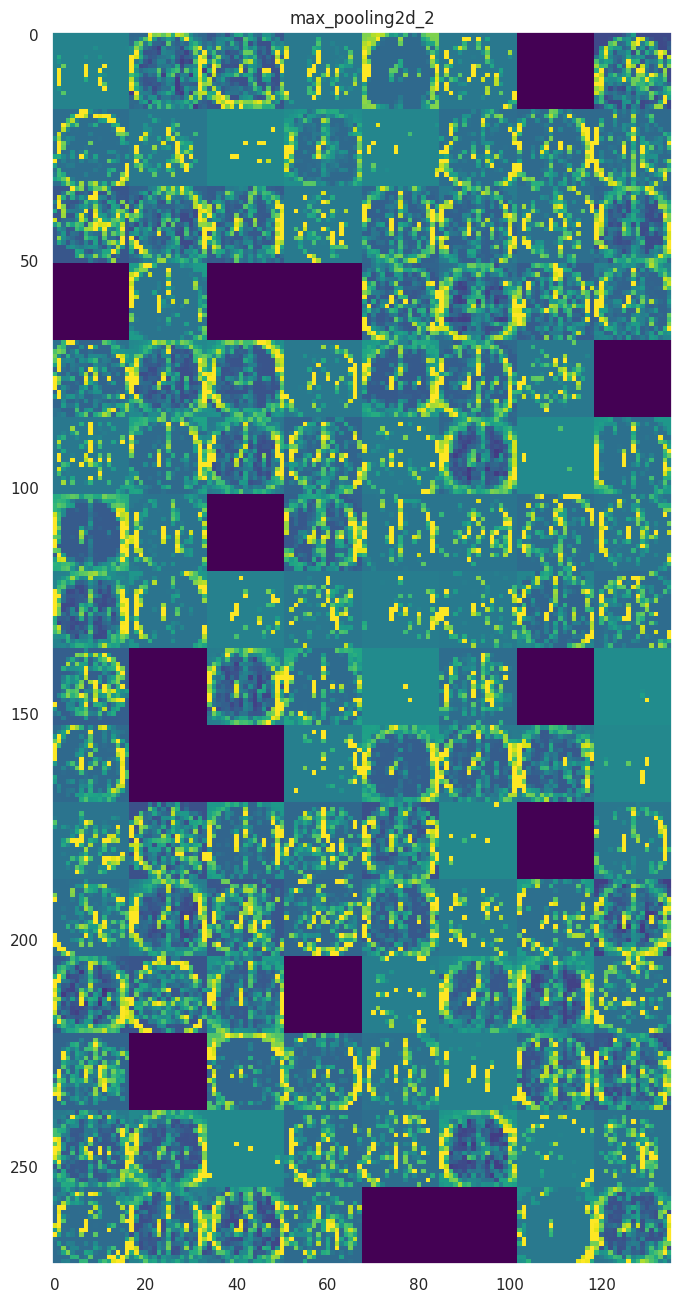

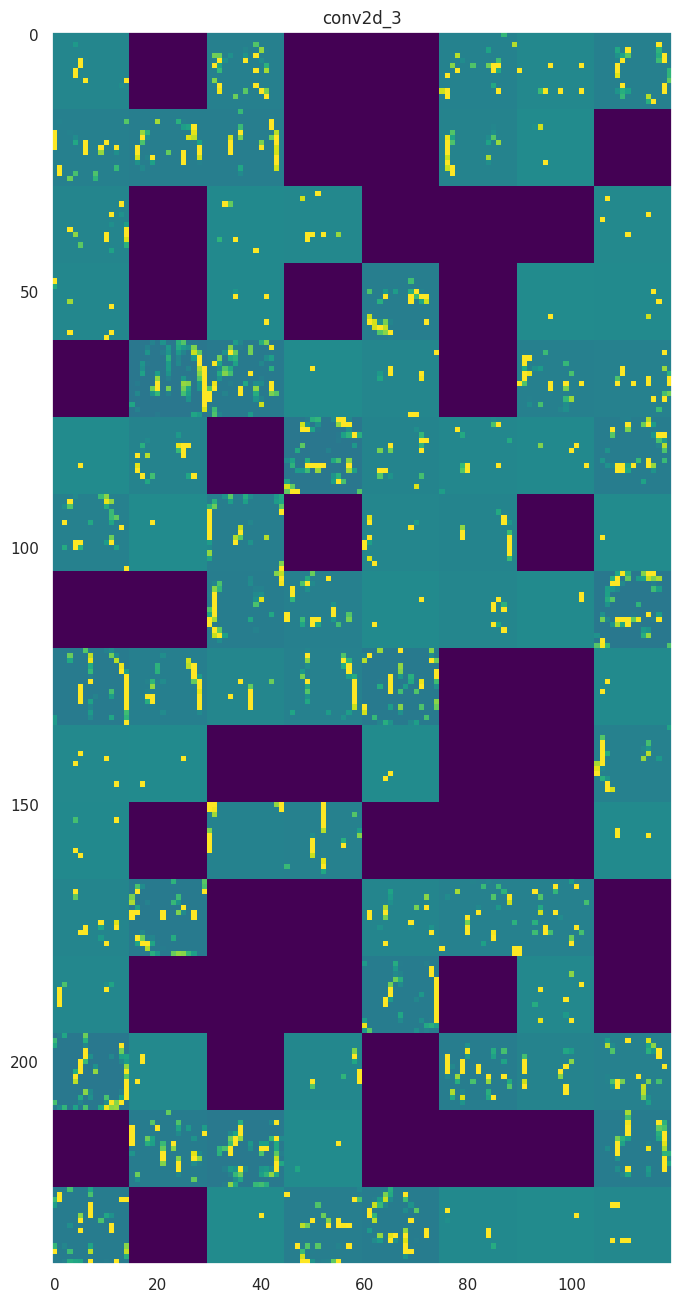

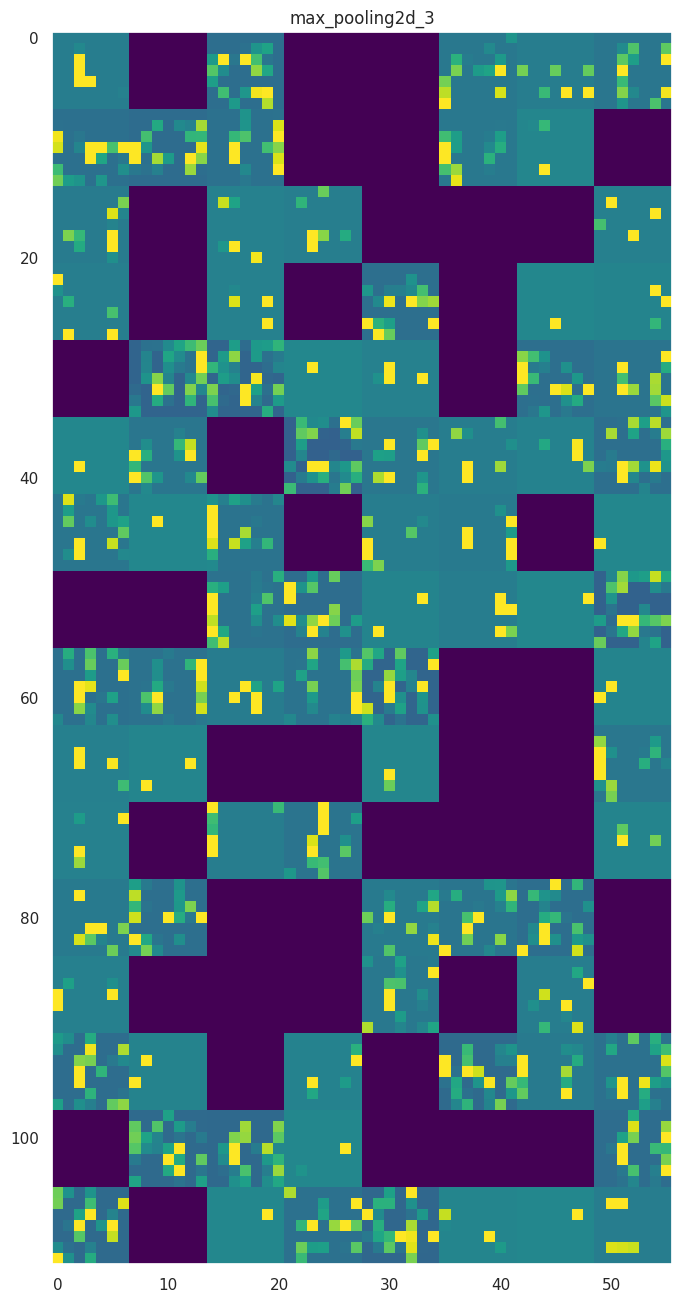

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model

# 1. Your specific list of layer names
layer_names = [
    'conv2d', 'max_pooling2d',
    'conv2d_1', 'max_pooling2d_1',
    'conv2d_2', 'max_pooling2d_2',
    'conv2d_3', 'max_pooling2d_3'
]

# Ensure the model is built before accessing its input
if not model.built:
    model.build(input_shape=(None, 150, 150, 3))

# 2. Get the output tensor from each of these layers
# We verify the layer exists to avoid errors
layer_outputs = [model.get_layer(name).output for name in layer_names]

# 3. Create a single model that returns all these outputs at once
activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)

# 4. Predict (Run the image through the model)
# Using img_tensor which was defined in previous cells (e.g., K8UqIpG2HrOA or IQ2umdgSmzwy)
# If running this cell independently, ensure img_tensor is in scope.
if 'img_tensor' not in locals():
    print("Warning: 'img_tensor' not found. Please ensure it's defined or run previous cells.")
    # Fallback to create a dummy tensor if img_tensor is not available
    img_tensor = np.random.rand(1, 150, 150, 3).astype('float32') # Use float32 for Keras input

activations = activation_model.predict(img_tensor)

# 5. Visualization Loop
# We zip the names with the results to iterate through them together
images_per_row = 8

for layer_name, layer_activation in zip(layer_names, activations):

    # layer_activation shape is (1, height, width, n_features)
    n_features = layer_activation.shape[-1] # Number of filters in this layer
    size = layer_activation.shape[1]        # The feature map size (e.g., 150, 75, etc.)

    # We tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Fill the grid with the filter images
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]

            # Post-process the feature to make it visually pleasing
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            # Place into grid
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()